In [1]:
import matplotlib.pyplot as plt
import numpy as np
from brian2.only import *
import seaborn as sns
import deepdish as dd
import scipy.stats as stats

import plot_utils as pu
from digest import conds, get_digest_output, get_voltages, get_voltage_histograms
import isi_indexing as ii
from readout import load_results
import digest

import conf.isi5_500 as cfg
from demonstrator import demonstrator

In [2]:
nspikes = dd.io.load('Fig5n-stats.h5')

### Response in all conditions is smaller with STD than without

Text(0, 0.5, '# spikes per trial')

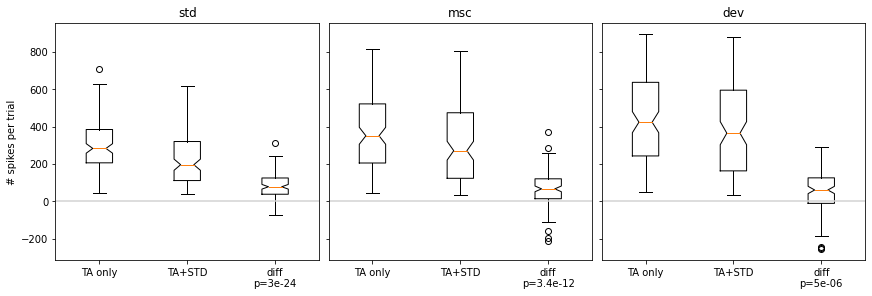

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(12,4), constrained_layout=True, sharey=True)
for ax, cond in zip(axs, conds):
    X_full = nspikes[1][1][cond]
    X_taonly = nspikes[0][1][cond]
    y = [X_taonly, X_full, X_taonly-X_full]
    ax.boxplot(y, positions=range(3), notch=True)
    ax.axhline(0, color='lightgrey')
    ax.set_title(cond)
    test = stats.ttest_rel(X_full, X_taonly, alternative='less')
    ax.set_xticklabels(('TA only', 'TA+STD', f'diff\np={test.pvalue:.2g}'))
axs[0].set_ylabel('# spikes per trial')

std > 0: t = 13, p = 3e-24
msc > 0: t = 7.6, p = 3.4e-12
dev > 0: t = 4.6, p = 5e-06


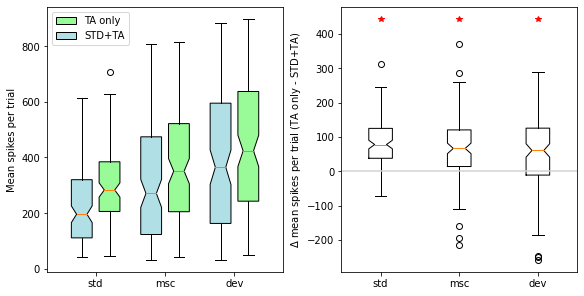

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)
X_taonly = [nspikes[0][1][cond] for cond in conds]
X_full = [nspikes[1][1][cond] for cond in conds]
X_diff = [o-f for o, f in zip(X_taonly, X_full)]
pos2 = np.arange(3)
pos1 = np.arange(3)+.4
c1, c2 = 'palegreen', 'powderblue'

b = axs[0].boxplot(X_taonly, positions=pos1, notch=True, patch_artist=True)
for patch in b['boxes']:
    patch.set_facecolor(c1)
axs[0].fill_between([], [], [], label='TA only', color=c1, ec='k')

b = axs[0].boxplot(X_full, positions=pos2, notch=True, patch_artist=True)
for patch in b['boxes']:
    patch.set_facecolor(c2)
axs[0].fill_between([], [], [], label='STD+TA', color=c2, ec='k')

axs[0].set_xticks((pos1+pos2)/2, conds)
axs[0].set_ylabel('Mean spikes per trial')
axs[0].legend()

axs[1].boxplot(X_diff, notch=True)
axs[1].axhline(0, color='lightgrey')
axs[1].set_ylabel('$\\Delta$ mean spikes per trial (TA only - STD+TA)')
axs[1].set_xticks(range(1,4), conds)
vmax = np.max(X_diff)
for i, (cond, diff) in enumerate(zip(conds, X_diff)):
    test = stats.ttest_1samp(diff, 0, alternative='greater')
    print(f'{cond} > 0: t = {test.statistic:.2g}, p = {test.pvalue:.2g}')
    if test.pvalue > 0:
        plt.plot(i+1, vmax*1.2, 'r*')

### Response is reduced most (in absolute terms) in std, least in dev

In [5]:
for i, cond in enumerate(conds):
    dX = nspikes[0][1][cond] - nspikes[1][1][cond]
    for cond1 in conds[i+1:]:
        dX1 = nspikes[0][1][cond1] - nspikes[1][1][cond1]
        test = stats.ttest_rel(dX, dX1, alternative='greater')
        print(cond, '>', cond1, f'(t = {test.statistic:.2g}, p = {test.pvalue:.2g})')

std > msc (t = 1.9, p = 0.03)
std > dev (t = 4.2, p = 2.4e-05)
msc > dev (t = 3, p = 0.0017)


In [6]:
def index(n0, n1):
    return ((n0-n1)/(n0+n1))

### Response is reduced most (in relative terms) in std, least in dev

In [7]:
for i, cond in enumerate(conds):
    dX = index(nspikes[0][1][cond], nspikes[1][1][cond])
    for cond1 in conds[i+1:]:
        dX1 = index(nspikes[0][1][cond1], nspikes[1][1][cond1])
        print(cond, '>', cond1, stats.ttest_rel(dX, dX1, alternative='greater'))

std > msc Ttest_relResult(statistic=3.633185723407874, pvalue=0.0002072232909545031)
std > dev Ttest_relResult(statistic=5.546802848214789, pvalue=8.927680799609423e-08)
msc > dev Ttest_relResult(statistic=3.2993616138061506, pvalue=0.0006393736463931023)


### Smaller response does not generally lead to greater reduction

0.16011408761789167 0.08065604866654084
0.16652842057478148 0.06908725593756823
0.05978425325615773 0.5165779549102336


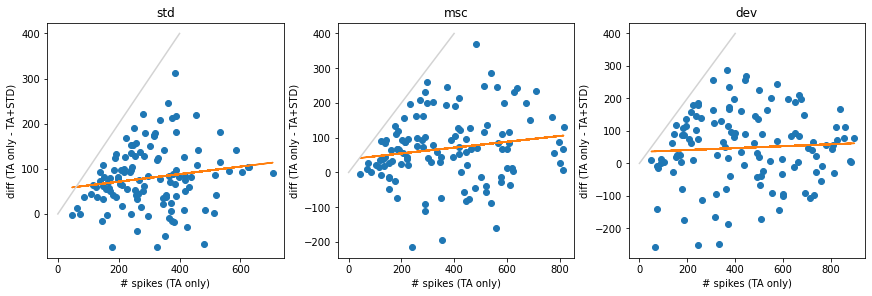

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(12,4), constrained_layout=True)
for ax, cond in zip(axs, conds):
    X_full = nspikes[1][1][cond]
    X_taonly = nspikes[0][1][cond]
    ax.scatter(X_taonly, X_taonly-X_full)
    reg = stats.linregress(X_taonly, X_taonly-X_full)
    ax.plot(X_taonly, reg.intercept + X_taonly*reg.slope, 'C1')
    print(reg.rvalue, reg.pvalue)
    ax.set_title(cond)
    ax.set_xlabel('# spikes (TA only)')
    ax.set_ylabel('diff (TA only - TA+STD)')
    
    ax.plot([0, 400], [0, 400], 'lightgrey')

In [9]:
isi, STD, TA, templ = 500, 1, 1, 0
net, ipair, istim = [demonstrator[k] for k in ('net', 'ipair', 'istim')]
pair, stim, Bstim = cfg.pairings[ipair], cfg.pairings[ipair][istim], cfg.pairings[ipair][1-istim]
res = load_results(cfg.fname.format(net=net, isi=isi, STD=STD, TA=TA, templ=templ))
res['voltage_histograms'] = get_voltage_histograms(cfg.params, res)
res['processed_dynamics'] = get_voltages(cfg.params, res['raw_dynamics'])

In [10]:
episodes = {cond: res['pairs'][ipair][cond][stim] for cond in conds}
sequences = {cond: res['sequences'][episode] for cond, episode in episodes.items()}
trials = {cond: seq == cfg.stimuli[stim] for cond, seq in sequences.items()}
trials.update({f'{cond}-nontarget': seq != cfg.stimuli[stim] for cond, seq in sequences.items()})
trials.update({f'{cond}-B': seq == cfg.stimuli[cfg.pairings[ipair][1-istim]] for cond, seq in sequences.items()})

In [11]:
nanspikes = np.full(res['raw_dynamics']['v'].shape, np.nan)
for episode, epspikes in res['raw_spikes'].items():
    for itrial, (i, spike_t) in enumerate(zip(*[epspikes[f'pulsed_{k}'] for k in 'it'])):
        t = (spike_t / cfg.params['dt'] + .5).astype(int)
        nanspikes[i, episode, itrial, t] = 1

In [12]:
bspikes = {}
for cond in conds:
    bspikes[cond] = np.zeros((cfg.params['N'], len(sequences[cond]), res['raw_dynamics']['v'].shape[-1]), bool)
    for itrial, (i, spike_t) in enumerate(zip(*[res['raw_spikes'][episodes[cond]][k] for k in ('pulsed_i', 'pulsed_t')])):
        t = (spike_t / cfg.params['dt'] + .5).astype(int)
        bspikes[cond][i, itrial, t] = True
    assert np.all(bspikes[cond].sum(2) == res['raw_spikes'][episodes[cond]]['pulsed_nspikes'].T)

In [13]:
netf = dd.io.load(cfg.netfile.format(net=net))
X, Y = netf['X']/cfg.params['r_dish'].item(), netf['Y']/cfg.params['r_dish'].item()
W = netf['W']
Wb = W>0

In [14]:
def scatter_values(ax, **kwargs):
    m = ax.scatter(X, Y, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    sns.despine(ax=ax, left=True, bottom=True)
    return m

In [15]:
ms = 20

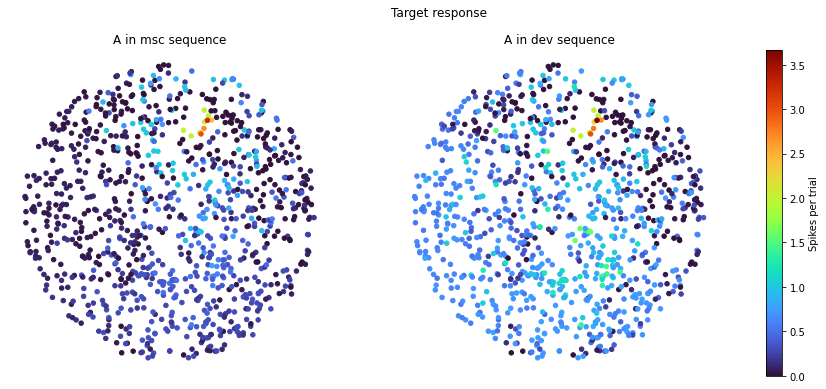

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
XA_dev = bspikes['dev'][:, sequences['dev']==cfg.stimuli[stim]].sum(2).mean(1)
XA_msc = bspikes['msc'][:, sequences['msc']==cfg.stimuli[stim]].sum(2).mean(1)
vmax = max(*[val.max() for val in (XA_dev, XA_msc)])
vmin = min(*[val.min() for val in (XA_dev, XA_msc)])

fig.suptitle('Target response')
scatter_values(axs[0], c=XA_msc, s=ms, vmin=vmin, vmax=vmax, cmap='turbo')
axs[0].set_title('A in msc sequence')
m = scatter_values(axs[1], c=XA_dev, s=ms, vmin=vmin, vmax=vmax, cmap='turbo')
axs[1].set_title('A in dev sequence')
plt.colorbar(m, ax=axs, label='Spikes per trial')

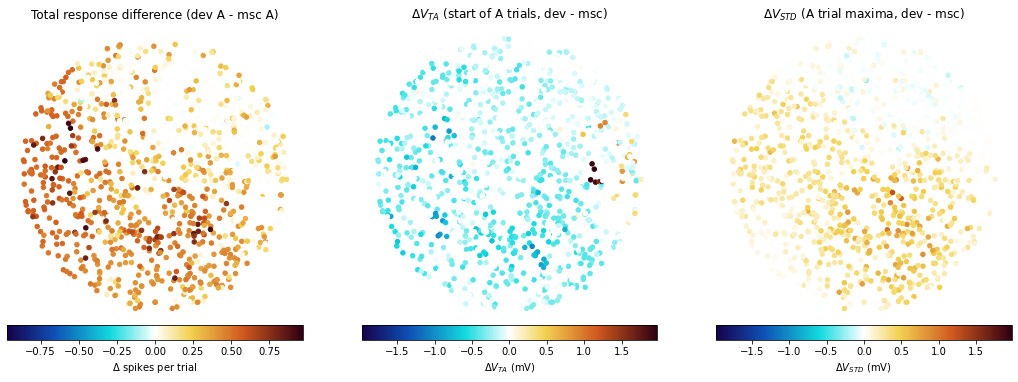

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(18,6.5))
diff_XA = XA_dev - XA_msc
dTA = (
    res['processed_dynamics']['Threshold'][:, episodes['dev'], trials[f'dev'], 0].mean(1)
    - res['processed_dynamics']['Threshold'][:, episodes['msc'], trials[f'msc'], 0].mean(1))*volt/mV
dSTD = (
    res['processed_dynamics']['Depression'][:, episodes['dev'], trials[f'dev'], :].max(-1).mean(1)
    - res['processed_dynamics']['Depression'][:, episodes['msc'], trials[f'msc'], :].max(-1).mean(1))*volt/mV

vmax = np.abs(diff_XA).max()
m = scatter_values(axs[0], c=diff_XA, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[0].set_title('Total response difference (dev A - msc A)')
plt.colorbar(m, ax=axs[0], orientation='horizontal', pad=0, label='$\\Delta$ spikes per trial')

vmax = np.abs([dTA, dSTD]).max()
m = scatter_values(axs[1], c=dTA, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[1].set_title('$\\Delta V_{TA}$ (start of A trials, dev - msc)')
plt.colorbar(m, ax=axs[1], orientation='horizontal', pad=0, label='$\\Delta V_{TA}$ (mV)')

# vmax = np.abs(dSTD).max()
m = scatter_values(axs[2], c=dSTD, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[2].set_title('$\\Delta V_{STD}$ (A trial maxima, dev - msc)')
plt.colorbar(m, ax=axs[2], orientation='horizontal', pad=0, label='$\\Delta V_{STD}$ (mV)')

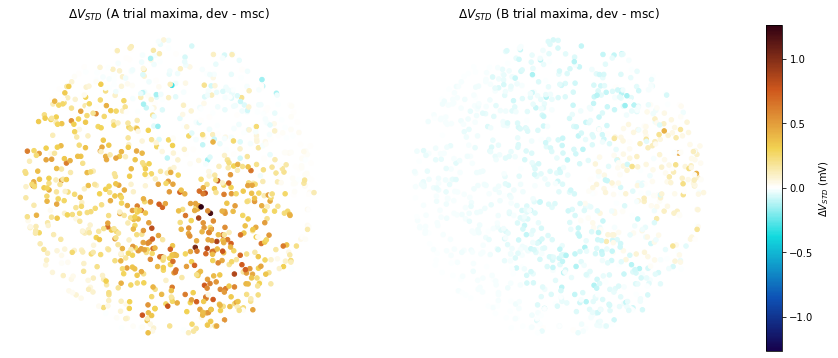

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
dSTD_A = (
    res['processed_dynamics']['Depression'][:, episodes['dev'], trials[f'dev'], :].max(-1).mean(1)
    - res['processed_dynamics']['Depression'][:, episodes['msc'], trials[f'msc'], :].max(-1).mean(1))*volt/mV
dSTD_B = (
    res['processed_dynamics']['Depression'][:, episodes['dev'], trials[f'dev-B'], :].max(-1).mean(1)
    - res['processed_dynamics']['Depression'][:, episodes['msc'], trials[f'msc-B'], :].max(-1).mean(1))*volt/mV

vmax = np.abs([dSTD_A, dSTD_B]).max()
m = scatter_values(axs[0], c=dSTD_A, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[0].set_title('$\\Delta V_{STD}$ (A trial maxima, dev - msc)')
m = scatter_values(axs[1], c=dSTD_B, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[1].set_title('$\\Delta V_{STD}$ (B trial maxima, dev - msc)')
plt.colorbar(m, ax=axs, label='$\\Delta V_{STD}$ (mV)')

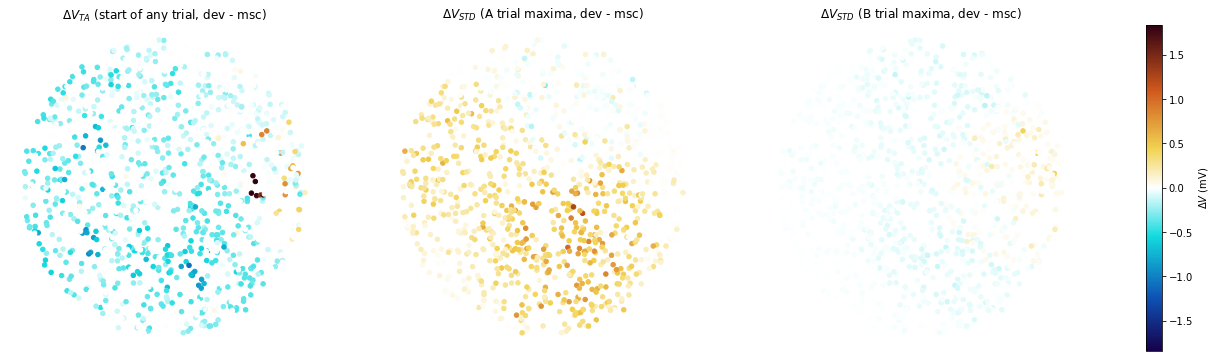

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(24,6))
dTA_all = (
    res['processed_dynamics']['Threshold'][:, episodes['dev'], :, 0].mean(1)
    - res['processed_dynamics']['Threshold'][:, episodes['msc'], :, 0].mean(1))*volt/mV
vmax = np.abs([dTA_all, dSTD_A, dSTD_B]).max()

m = scatter_values(axs[0], c=dTA_all, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[0].set_title('$\\Delta V_{TA}$ (start of any trial, dev - msc)')
m = scatter_values(axs[1], c=dSTD_A, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[1].set_title('$\\Delta V_{STD}$ (A trial maxima, dev - msc)')
m = scatter_values(axs[2], c=dSTD_B, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[2].set_title('$\\Delta V_{STD}$ (B trial maxima, dev - msc)')
plt.colorbar(m, ax=axs, label='$\\Delta V$ (mV)')

In [20]:
k = 1.4

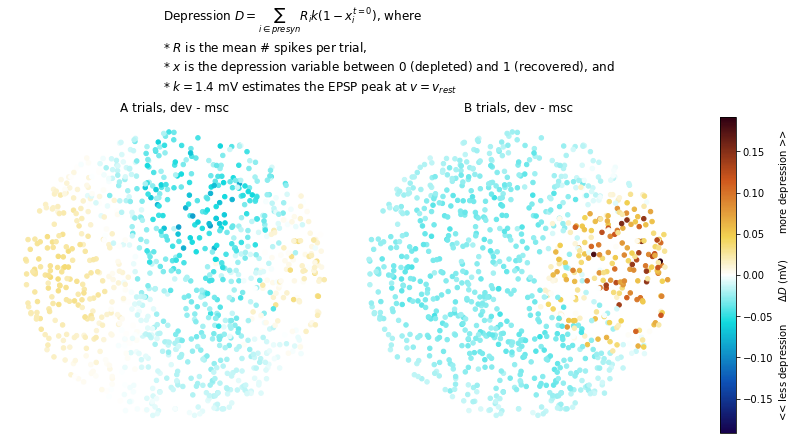

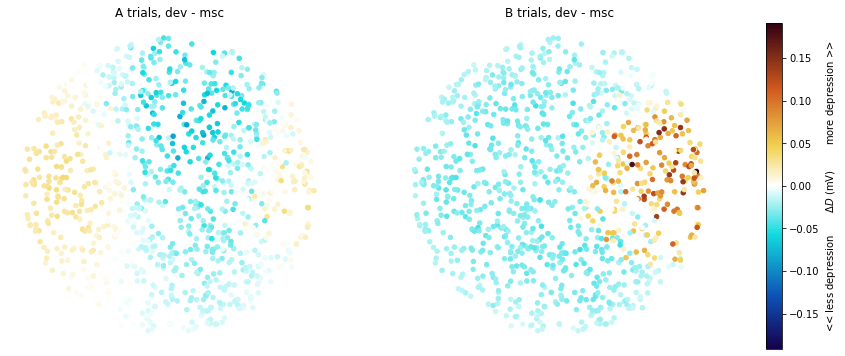

In [21]:
XA_dev = bspikes['dev'][:, trials['dev']].sum(2).mean(1)
XA_msc = bspikes['msc'][:, trials['msc']].sum(2).mean(1)
xr0_A_dev = 1-res['raw_dynamics']['neuron_xr'][:, episodes['dev'], trials['dev'], 0].mean(1)
xr0_A_msc = 1-res['raw_dynamics']['neuron_xr'][:, episodes['msc'], trials['msc'], 0].mean(1)
xr0_A_post_weighted_dev = np.einsum('eo,e->o', Wb, XA_dev*xr0_A_dev) * k
xr0_A_post_weighted_msc = np.einsum('eo,e->o', Wb, XA_msc*xr0_A_msc) * k
dxr0_A_post_weighted = xr0_A_post_weighted_dev - xr0_A_post_weighted_msc

XB_dev = bspikes['dev'][:, trials['dev-B']].sum(2).mean(1)
XB_msc = bspikes['msc'][:, trials['msc-B']].sum(2).mean(1)
xr0_B_dev = 1-res['raw_dynamics']['neuron_xr'][:, episodes['dev'], trials['dev-B'], 0].mean(1)
xr0_B_msc = 1-res['raw_dynamics']['neuron_xr'][:, episodes['msc'], trials['msc-B'], 0].mean(1)
xr0_B_post_weighted_dev = np.einsum('eo,e->o', Wb, XB_dev*xr0_B_dev) * k
xr0_B_post_weighted_msc = np.einsum('eo,e->o', Wb, XB_msc*xr0_B_msc) * k
dxr0_B_post_weighted = xr0_B_post_weighted_dev - xr0_B_post_weighted_msc

fig, axs = plt.subplots(1, 2, figsize=(11,6), constrained_layout=True)
vmax = np.abs([dxr0_A_post_weighted, dxr0_B_post_weighted]).max()
m = scatter_values(axs[0], c=dxr0_A_post_weighted, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[0].set_title('A trials, dev - msc')
m = scatter_values(axs[1], c=dxr0_B_post_weighted, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[1].set_title('B trials, dev - msc')
plt.colorbar(m, ax=axs, label='<< less depression\t $\\Delta D$ (mV) \tmore depression >>')

fig.suptitle('Depression $D = \\sum_{i \\in presyn} R_i k (1-x_i^{t=0})$, where\n* $R$ is the mean # spikes per trial,\n'
    '* $x$ is the depression variable between 0 (depleted) and 1 (recovered), and\n'
    '* $k=1.4$ mV estimates the EPSP peak at $v=v_{rest}$', x=.2, ha='left')

fig, axs = plt.subplots(1, 2, figsize=(16,6))
vmax = np.abs([dxr0_A_post_weighted, dxr0_B_post_weighted]).max()
m = scatter_values(axs[0], c=dxr0_A_post_weighted, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[0].set_title('A trials, dev - msc')
m = scatter_values(axs[1], c=dxr0_B_post_weighted, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[1].set_title('B trials, dev - msc')
plt.colorbar(m, ax=axs, label='<< less depression\t $\\Delta D$ (mV) \tmore depression >>')

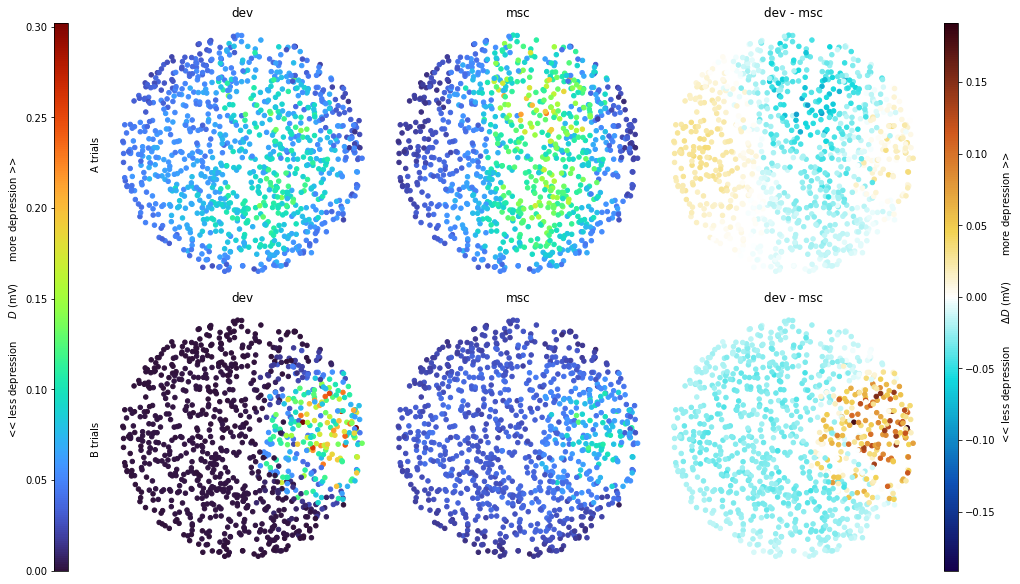

In [22]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8), constrained_layout=True)

vmax = np.abs([xr0_A_post_weighted_dev, xr0_A_post_weighted_msc, xr0_B_post_weighted_dev, xr0_B_post_weighted_msc]).max()
m = scatter_values(axs[0, 0], c=xr0_A_post_weighted_dev, s=ms, vmin=0, vmax=vmax, cmap='turbo')
axs[0, 0].set_title('dev')
m = scatter_values(axs[0, 1], c=xr0_A_post_weighted_msc, s=ms, vmin=0, vmax=vmax, cmap='turbo')
axs[0, 1].set_title('msc')
m = scatter_values(axs[1, 0], c=xr0_B_post_weighted_dev, s=ms, vmin=0, vmax=vmax, cmap='turbo')
axs[1, 0].set_title('dev')
m = scatter_values(axs[1, 1], c=xr0_B_post_weighted_msc, s=ms, vmin=0, vmax=vmax, cmap='turbo')
axs[1, 1].set_title('msc')
plt.colorbar(m, ax=axs, label='<< less depression\t $D$ (mV) \tmore depression >>', location='left', aspect=40, pad=0.02)
axs[0,0].set_ylabel('A trials')
axs[1,0].set_ylabel('B trials')

vmax = np.abs([dxr0_A_post_weighted, dxr0_B_post_weighted]).max()
m = scatter_values(axs[0, 2], c=dxr0_A_post_weighted, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[0, 2].set_title('dev - msc')
m = scatter_values(axs[1, 2], c=dxr0_B_post_weighted, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[1, 2].set_title('dev - msc')
plt.colorbar(m, ax=axs, label='<< less depression\t $\\Delta D$ (mV) \tmore depression >>', aspect=40, pad=0.02)

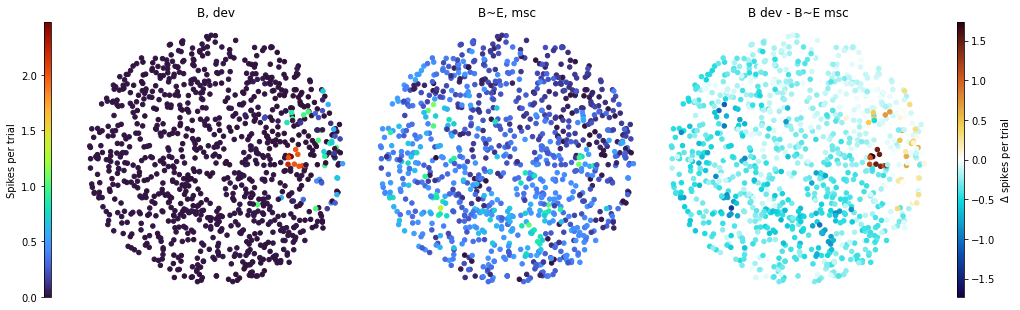

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4.2), constrained_layout=True)

XA_dev = bspikes['dev'][:, trials['dev']].sum(2).mean(1)
XA_msc = bspikes['msc'][:, trials['msc']].sum(2).mean(1)
dXA = XA_dev - XA_msc
XB_dev = bspikes['dev'][:, trials['dev-B']].sum(2).mean(1)
XnotA_msc = bspikes['msc'][:, ~trials['msc']].sum(2).mean(1)
dXnotA = XB_dev - XnotA_msc

vmax = np.abs([XB_dev, XnotA_msc]).max()
m = scatter_values(axs[0], c=XB_dev, s=ms, vmin=0, vmax=vmax, cmap='turbo')
axs[0].set_title('B, dev')
m = scatter_values(axs[1], c=XnotA_msc, s=ms, vmin=0, vmax=vmax, cmap='turbo')
axs[1].set_title('B~E, msc')
plt.colorbar(m, ax=axs, label='Spikes per trial', location='left', aspect=40, pad=0.02)

vmax = np.abs(dXnotA).max()
m = scatter_values(axs[2], c=dXnotA, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[2].set_title('B dev - B~E msc')
plt.colorbar(m, ax=axs, label='$\\Delta$ spikes per trial', aspect=40, pad=0.02)

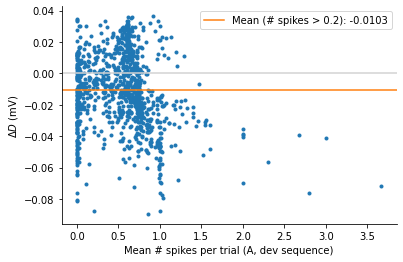

In [24]:
threshold = .2
plt.plot(XA_dev, dxr0_A_post_weighted, '.')
plt.axhline(0, color='lightgrey')
plt.xlabel('Mean # spikes per trial (A, dev sequence)')
plt.ylabel('$\\Delta D$ (mV)')
m = np.mean((XA_dev * dxr0_A_post_weighted)[XA_dev > threshold])
plt.axhline(m, color='C1')
plt.plot([], 'C1', label=f'Mean (# spikes > {threshold:.1f}): {m:.3g}')
plt.legend()
sns.despine()

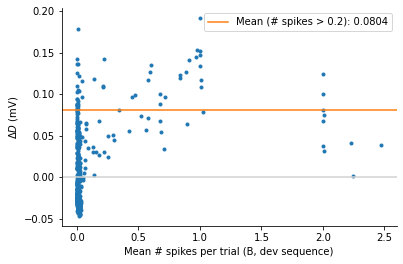

In [25]:
plt.plot(XB_dev, dxr0_B_post_weighted, '.')
plt.axhline(0, color='lightgrey')
plt.xlabel('Mean # spikes per trial (B, dev sequence)')
plt.ylabel('$\\Delta D$ (mV)')
m = np.mean((XB_dev * dxr0_B_post_weighted)[XB_dev > threshold])
plt.axhline(m, color='C1')
plt.plot([], 'C1', label=f'Mean (# spikes > {threshold:.1f}): {m:.3g}')
plt.legend()
sns.despine()

In [26]:
TA_A_dev = res['raw_dynamics']['th_adapt'][:, episodes['dev'], trials[f'dev'], 0].mean(1)*volt/mV
TA_A_msc = res['raw_dynamics']['th_adapt'][:, episodes['msc'], trials[f'msc'], 0].mean(1)*volt/mV
dTA_A = TA_A_dev - TA_A_msc
XA_dev = bspikes['dev'][:, trials['dev']].sum(2).mean(1)
TA_B_dev = res['raw_dynamics']['th_adapt'][:, episodes['dev'], trials[f'dev-B'], 0].mean(1)*volt/mV
TA_B_msc = res['raw_dynamics']['th_adapt'][:, episodes['msc'], trials[f'msc-B'], 0].mean(1)*volt/mV
dTA_B = TA_B_dev - TA_B_msc
XB_dev = bspikes['dev'][:, trials['dev-B']].sum(2).mean(1)

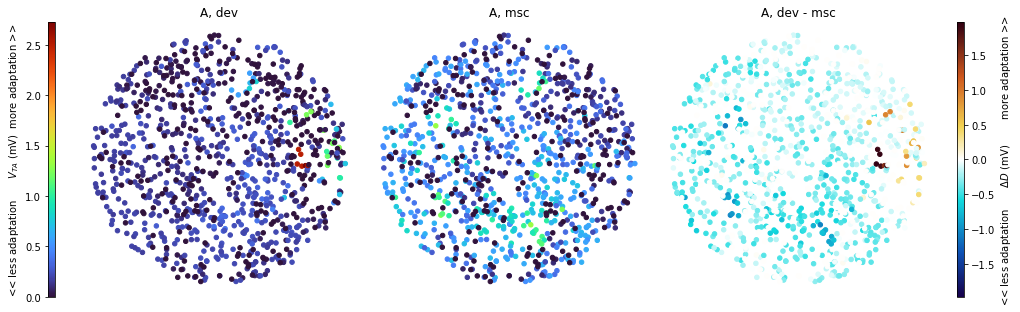

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4.2), constrained_layout=True)

vmax = np.abs([TA_A_dev, TA_A_msc]).max()
m = scatter_values(axs[0], c=TA_A_dev, s=ms, vmin=0, vmax=vmax, cmap='turbo')
axs[0].set_title('A, dev')
m = scatter_values(axs[1], c=TA_A_msc, s=ms, vmin=0, vmax=vmax, cmap='turbo')
axs[1].set_title('A, msc')
plt.colorbar(m, ax=axs, label='<< less adaptation\t $V_{TA}$ (mV) \tmore adaptation >>', location='left', aspect=40, pad=0.02)

vmax = np.abs(dTA_A).max()
m = scatter_values(axs[2], c=dTA_A, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[2].set_title('A, dev - msc')
plt.colorbar(m, ax=axs, label='<< less adaptation\t $\\Delta D$ (mV) \tmore adaptation >>', aspect=40, pad=0.02)

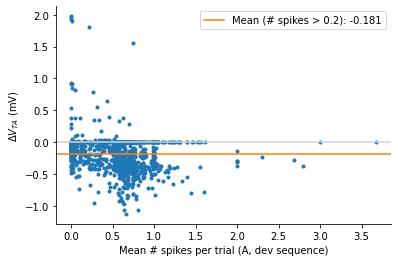

In [28]:
plt.plot(XA_dev, dTA_A, '.')
plt.axhline(0, color='lightgrey')
plt.xlabel('Mean # spikes per trial (A, dev sequence)')
plt.ylabel('$\\Delta V_{TA}$ (mV)')
m = np.mean((XA_dev * dTA_A)[XA_dev > threshold])
plt.axhline(m, color='C1')
plt.plot([], 'C1', label=f'Mean (# spikes > {threshold:.1f}): {m:.3g}')
plt.legend()
sns.despine()

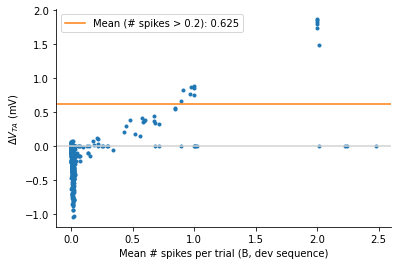

In [29]:
plt.plot(XB_dev, dTA_B, '.')
plt.axhline(0, color='lightgrey')
plt.xlabel('Mean # spikes per trial (B, dev sequence)')
plt.ylabel('$\\Delta V_{TA}$ (mV)')
m = np.mean((XB_dev * dTA_B)[XB_dev > threshold])
plt.axhline(m, color='C1')
plt.plot([], 'C1', label=f'Mean (# spikes > {threshold:.1f}): {m:.3g}')
plt.legend()
sns.despine()

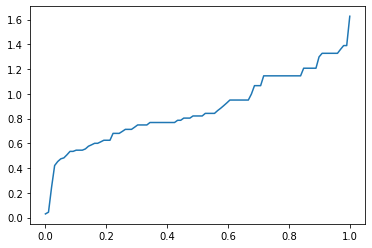

In [30]:
cutoff = np.linspace(0,1,100)
m = []
for c in cutoff:
    m.append(np.mean((XB_dev * dTA_B)[XB_dev > c]))
plt.plot(cutoff, m)

# Stats

In [31]:
def get_bspikes(res, episode):
    b = np.zeros(np.asarray(res['raw_dynamics']['v'].shape)[[0,2,3]], bool)
    for itrial, (i, spike_t) in enumerate(zip(*[res['raw_spikes'][episode][f'pulsed_{k}'] for k in 'it'])):
        t = (spike_t / cfg.params['dt'] + .5).astype(int)
        b[i, itrial, t] = True
    return b

In [33]:
def get_suppression_data(res, Wb, ipair, istim):
    Response = {AB: {} for AB in 'AB'}
    Threshold = {AB: {} for AB in 'AB'}
    Depression = {AB: {} for AB in 'AB'}

    # Response
    for cond in ('dev', 'msc'):
        episode = res['pairs'][ipair][cond][cfg.pairings[ipair][istim]]
        spikes = get_bspikes(res, episode)
        for isB, AB in enumerate('AB'):
            trials = res['sequences'][episode] == cfg.stimuli[cfg.pairings[ipair][(1-istim) if isB else istim]]
            Response[AB][cond] = spikes[:, trials].sum(2).mean(1)

    # Threshold
    for cond in ('dev', 'msc'):
        episode = res['pairs'][ipair][cond][cfg.pairings[ipair][istim]]
        for isB, AB in enumerate('AB'):
            trials = res['sequences'][episode] == cfg.stimuli[cfg.pairings[ipair][(1-istim) if isB else istim]]
            Threshold[AB][cond] = res['raw_dynamics']['th_adapt'][:, episode, trials, 0].mean(1)*volt/mV
        

    # Depression
    for cond in ('dev', 'msc'):
        episode = res['pairs'][ipair][cond][cfg.pairings[ipair][istim]]
        for isB, AB in enumerate('AB'):
            trials = res['sequences'][episode] == cfg.stimuli[cfg.pairings[ipair][(1-istim) if isB else istim]]
            xr = res['raw_dynamics']['neuron_xr'][:, episode, trials, 0].mean(1)
            Depression[AB][cond] = np.einsum('eo,e->o', Wb, Response[AB][cond] * k * (1-xr))
    
    return Response, Threshold, Depression

def get_mean_suppression(Rdata, TAdata, Ddata, threshold=.2, k=1.4):
    summary = {
        AB: {
            'TA': (Rdata[AB]['dev'] * (TAdata[AB]['dev']-TAdata[AB]['msc']))[Rdata[AB]['dev'] > threshold].mean(),
            'D': (Rdata[AB]['dev'] * k * (Ddata[AB]['dev']-Ddata[AB]['msc']))[Rdata[AB]['dev'] > threshold].mean(),
        }
        for AB in 'AB'
    }
    return summary

# TODO:

In [38]:
isi, TA, templ = 500, 1, 0
Rdata, TAdata, Ddata = [{STD: [] for STD in cfg.STDs} for _ in range(3)]
for STD in cfg.STDs:
    for net in range(cfg.N_networks):
        res = load_results(
            cfg.fname.format(net=net, isi=isi, STD=STD, TA=TA, templ=templ),
            dynamics_supplements={'neuron_xr': 0},
            process_spikes=False, process_dynamics=False)
        netf = dd.io.load(cfg.netfile.format(net=net))
        Wb = netf['W'] > 0
        for ipair, pair in enumerate(cfg.pairings):
            for istim, stim in enumerate(pair):
                k = 2*len(cfg.pairings)*net + 2*ipair + istim
                data = get_suppression_data(res, Wb, ipair, istim)
                Rdata[STD].append(data[0])
                TAdata[STD].append(data[1])
                Ddata[STD].append(data[2])
        print(net, end=' ')
dd.io.save('Fig8-synergy.h5', {'R': Rdata, 'TA': TAdata, 'D': Ddata})

0 1 2 3 

KeyboardInterrupt: 

In [ ]:
Rdata = dd.io.load('Fig8-synergy.h5', '/R')
TAdata = dd.io.load('Fig8-synergy.h5', '/TA')
Ddata = dd.io.load('Fig8-synergy.h5', '/D')

In [43]:
dSuppression = {STD: {AB: {key: np.zeros(2*len(cfg.pairings)*cfg.N_networks)
    for key in ('TA','D')} for AB in 'AB'} for STD in cfg.STDs}
for STD in cfg.STDs:
    for k in range(len(Rdata[STD])):
        m = get_mean_suppression(Rdata[STD][k], TAdata[STD][k], Ddata[STD][k])
        for AB in 'AB':
            for key in ('TA', 'D'):
                dSuppression[STD][AB][key][k] = m[AB][key]

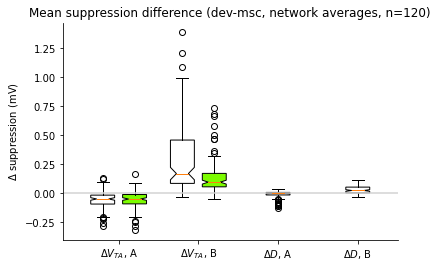

In [ ]:
b = plt.boxplot([
    dSuppression[1]['A']['TA'],
    dSuppression[0]['A']['TA'],
    dSuppression[1]['B']['TA'],
    dSuppression[0]['B']['TA'],
    dSuppression[1]['A']['D'],
    dSuppression[1]['B']['D']],
    positions=(0, 0.4, 1, 1.4, 2.2, 3.2), patch_artist=True, notch=True, widths=.3)
plt.axhline(0, color='lightgrey')
for i in (1, 3):
    b['boxes'][i].set_facecolor('lawngreen')
for i in (0, 2, 4, 5):
    b['boxes'][i].set_facecolor('white')
plt.xticks([0.2, 1.2, 2.2, 3.2], ['$\\Delta V_{TA}$, A', '$\\Delta V_{TA}$, B', '$\\Delta D$, A', '$\\Delta D$, B'])
plt.ylabel('$\\Delta$ suppression (mV)')
plt.title('Mean suppression difference (dev-msc, network averages, n=120)')
sns.despine()